In [44]:
#imports
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()

import altair as alt
from vega_datasets import data

In [45]:
#load datasets
vaccinations = pd.read_csv("COVID-19_Vaccinations.csv", low_memory=False)
covid_cases = pd.read_csv("covid_confirmed_usafacts.csv", low_memory=False)
death_cases = pd.read_csv("covid_deaths_usafacts.csv", low_memory=False)
gdp_by_county = pd.read_csv("GDP by County.csv", low_memory=False)

fips_data = pd.read_csv("https://raw.githubusercontent.com/kjhealy/fips-codes/master/state_and_county_fips_master.csv")


In [47]:
def clean_gdp_by_county(df):
    # reformating
    # Drop rows where all cells are NaN
    df = df.iloc[1:]
    df = df.dropna(how='all')
    states = [
        "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado",
        "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois",
        "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
        "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana",
        "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York",
        "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
        "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
        "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
    ]

    # Drop rows where the index (county) is actually a state name
    df = df[~df.index.isin(states)]
    df.set_index("County", inplace=True)
    return df
gdp_by_county = clean_gdp_by_county(gdp_by_county)


KeyError: "None of ['County'] are in the columns"

In [48]:
def clean_vax_df(df_vax):
    #clean vaccination dataset
    # Convert the 'Date' column to datetime format
    df_vax["Date"] = pd.to_datetime(df_vax["Date"], format="%m/%d/%Y")

    # Extract Year, Month, and Day
    df_vax["Year"] = df_vax["Date"].dt.year
    df_vax["Month"] = df_vax["Date"].dt.month
    df_vax["Day"] = df_vax["Date"].dt.day

    df_vax["Recip_County"] = df_vax["Recip_County"].str.replace(" County", "").str.strip()

    # Rename columns to match indexing convention
    df_vax = df_vax.rename(columns={"Recip_County": "County", "Recip_State": "State"})

    # Select only relevant columns
    df_vax = df_vax[["State", "County", "Year", "Month", "Day", "Series_Complete_Yes", 
                    "Series_Complete_Pop_Pct", "Booster_Doses_Vax_Pct"]]

    # Set the multi-index
    df_vax.set_index(["State", "County", "Year", "Month", "Day"], inplace=True)
    return df_vax

vaccinations = clean_vax_df(vaccinations)

In [49]:
def clean_cases_df(df_cases):
    # Standardize county names (remove " County")
    df_cases["County Name"] = df_cases["County Name"].str.replace(" County", "").str.strip()

    # Rename columns for consistency
    df_cases = df_cases.rename(columns={"County Name": "County", "State": "State"})

    # Drop unnecessary columns
    df_cases = df_cases.drop(columns=["countyFIPS", "StateFIPS"])

    # Convert wide format (dates as columns) to long format
    df_cases = df_cases.melt(id_vars=["State", "County"], var_name="Date", value_name="Cases")

    # Convert Date column to datetime and extract Year, Month, Day
    df_cases["Date"] = pd.to_datetime(df_cases["Date"])
    df_cases["Year"] = df_cases["Date"].dt.year
    df_cases["Month"] = df_cases["Date"].dt.month
    df_cases["Day"] = df_cases["Date"].dt.day


    # Drop the original Date column
    df_cases.drop(columns=["Date"], inplace=True)
    df_cases = df_cases[df_cases["County"] != "Statewide Unallocated"]

    # Set multi-index
    df_cases.set_index(["State", "County", "Year", "Month", "Day"], inplace=True)
    return df_cases
covid_cases = clean_cases_df(covid_cases)

In [50]:
def clean_deaths_df(df_deaths):
    '''
    TODO: Write Docstring
    '''
    # Drop unnecessary columns
    df_deaths = df_deaths.drop(columns=["countyFIPS", "StateFIPS"], errors="ignore")

    # Rename columns for consistency
    df_deaths = df_deaths.rename(columns={"County Name": "County", "State": "State"})

    # Standardize county names (remove "County" and extra spaces)
    df_deaths["County"] = df_deaths["County"].str.replace(" County", "").str.strip()

    # Remove rows where County is "Statewide Unallocated"
    df_deaths = df_deaths[df_deaths["County"] != "Statewide Unallocated"]

    # Reshape from wide format to long format
    df_deaths = df_deaths.melt(id_vars=["State", "County"], var_name="Date", value_name="Deaths")

    # Convert Date column to datetime format
    df_deaths["Date"] = pd.to_datetime(df_deaths["Date"], format="%Y-%m-%d")

    # Extract Year, Month, and Day
    df_deaths["Year"] = df_deaths["Date"].dt.year
    df_deaths["Month"] = df_deaths["Date"].dt.month
    df_deaths["Day"] = df_deaths["Date"].dt.day

    # Drop the original Date column
    df_deaths.drop(columns=["Date"], inplace = True)

    # Set multi-index
    df_deaths.set_index(["State", "County", "Year", "Month", "Day"], inplace=True)
    return df_deaths
death_cases = clean_deaths_df(death_cases)

In [51]:
def merge_datasets():
    '''
    TODO: Write Docstring
    '''

    #CHANGED FROM OUTER -> INNER
    df_combined = covid_cases.merge(death_cases, on=["State", "County", "Year", "Month", "Day"], how="inner")
    df_combined = df_combined.merge(vaccinations, on=["State", "County", "Year", "Month", "Day"], how="inner")
    
    #setup so we can merge on county
    df_combined = df_combined.reset_index()
    gdp_reset = gdp_by_county.reset_index()

    df_combined = pd.merge(df_combined, gdp_reset, on="County", how="left")
    df_combined = df_combined.set_index(["State", "County", "Year", "Month", "Day"])
    
    return df_combined
df_combined = merge_datasets()

In [52]:
def clean_fips_data(df):
    '''
    TODO: Write Docstring
    '''
    df.dropna(how="any", inplace=True)
    df.columns = ["FIPS", "County", "State"]
    df['County'] = df['County'].str.replace(r'\s*County$', '', regex=True)
    

clean_fips_data(fips_data)
display(fips_data)

FIPS      County State
2      1001     Autauga    AL
3      1003     Baldwin    AL
4      1005     Barbour    AL
5      1007        Bibb    AL
6      1009      Blount    AL
...     ...         ...   ...
3190  56037  Sweetwater    WY
3191  56039       Teton    WY
3192  56041       Uinta    WY
3193  56043    Washakie    WY
3194  56045      Weston    WY

[3143 rows x 3 columns]

In [53]:
def merge_FIPS(df):
    '''
    TODO: Write Docstring
    '''
    df_reset = df.reset_index()
    fips_data.dropna(how="any", inplace=True)

    df_new = df_reset.merge(fips_data, on=["County","State"], how="inner")
    df_new.set_index(["State", "County", "Year", "Month", "Day"], inplace=True)
    return df_new
df_combined = merge_FIPS(df_combined)

In [54]:
def reformat_GDP(df):
    #turn gdp2x -> gdp column for a give year
    df['GDP'] = df.apply(lambda row: row[f'GDP_{str(row.name[2])[-2:]}'], axis=1)

    # # #TESTING W THIS -- too many rows
    df.dropna(how='all', inplace=True)

    gdp_columns = ['GDP_20', 'GDP_21', 'GDP_22', 'GDP_23']

    # # Remove commas if present and convert each column to an integer
    for col in gdp_columns:
        df[col] =  df[col].str.replace(',', '').astype(float)  

    df['GDP_GROWTH'] = (df['GDP_23'] - df['GDP_20']) / df['GDP_20']
    
    display(df)
    # #drop og gdp columns
    df.drop(columns=["GDP_20","GDP_21","GDP_22","GDP_23"], inplace=True)
    #df.drop(columns=["level_0"])
    

    # Convert GDP to numeric if it's stored as strings with commas
    df['GDP'] = df['GDP'].str.replace(',', '').astype(float)   


    
    return df
reformat_GDP(df_combined) #diff ver. with less rows

Cases  Deaths  Series_Complete_Yes  \
State County   Year Month Day                                       
AL    Autauga  2020 12    13    3233      41                  0.0   
      Baldwin  2020 12    13   10489     141                  0.0   
                          13   10489     141                  0.0   
      Barbour  2020 12    13    1264      30                  0.0   
                          13    1264      30                  0.0   
...                              ...     ...                  ...   
WY    Teton    2023 5     10   12163      16              22802.0   
                          10   12163      16              22802.0   
      Uinta    2023 5     10    6447      43              10932.0   
      Washakie 2023 5     10    2703      51               3525.0   
      Weston   2023 5     10    1911      24               2706.0   

                               Series_Complete_Pop_Pct  Booster_Doses_Vax_Pct  \
State County   Year Month Day                                                   
AL    Autauga  2020 12    13                       0.0                    NaN   
      Baldwin  2020 12    13                       0.0                    NaN   
                          13                       0.0                    NaN   
      Barbour  2020 12    13                       0.0                    NaN   
                          13                       0.0                    NaN   
...                                                ...                    ...   
WY    Teton    2023 5     10                      95.0                   51.6   
                          10                      95.0                   51.6   
      Uinta    2023 5     10                      54.0                   43.0   
      Washakie 2023 5     10                      45.2                   51.3   
      Weston   2023 5     10                      39.1                   51.7   

                                  GDP_20     GDP_21     GDP_22     GDP_23  \
State County   Year Month Day                                               
AL    Autauga  2020 12    13   1746979.0  1736001.0  1895751.0  1945909.0   
      Baldwin  2020 12    13   8109210.0  8706236.0  9145388.0  9435720.0   
                          13   1318847.0  1408198.0  1423949.0  1471197.0   
      Barbour  2020 12    13    732151.0   753330.0   744850.0   715994.0   
                          13    385492.0   385192.0   480854.0   481017.0   
...                                  ...        ...        ...        ...   
WY    Teton    2023 5     10    269038.0   217413.0   265696.0   293022.0   
                          10   2688047.0  3541564.0  3543143.0  3695069.0   
      Uinta    2023 5     10    781034.0   808678.0   836424.0   870000.0   
      Washakie 2023 5     10    342040.0   346039.0   339019.0   347700.0   
      Weston   2023 5     10    290300.0   295003.0   289622.0   317107.0   

                                FIPS        GDP  GDP_GROWTH  
State County   Year Month Day                                
AL    Autauga  2020 12    13    1001  1,746,979    0.113871  
      Baldwin  2020 12    13    1003  8,109,210    0.163581  
                          13    1003  1,318,847    0.115518  
      Barbour  2020 12    13    1005    732,151   -0.022068  
                          13    1005    385,492    0.247800  
...                              ...        ...         ...  
WY    Teton    2023 5     10   56039    293,022    0.089147  
                          10   56039  3,695,069    0.374630  
      Uinta    2023 5     10   56041    870,000    0.113908  
      Washakie 2023 5     10   56043    347,700    0.016548  
      Weston   2023 5     10   56045    317,107    0.092342  

[8772660 rows x 12 columns]

Cases  Deaths  Series_Complete_Yes  \
State County   Year Month Day                                       
AL    Autauga  2020 12    13    3233      41                  0.0   
      Baldwin  2020 12    13   10489     141                  0.0   
                          13   10489     141                  0.0   
      Barbour  2020 12    13    1264      30                  0.0   
                          13    1264      30                  0.0   
...                              ...     ...                  ...   
WY    Teton    2023 5     10   12163      16              22802.0   
                          10   12163      16              22802.0   
      Uinta    2023 5     10    6447      43              10932.0   
      Washakie 2023 5     10    2703      51               3525.0   
      Weston   2023 5     10    1911      24               2706.0   

                               Series_Complete_Pop_Pct  Booster_Doses_Vax_Pct  \
State County   Year Month Day                                                   
AL    Autauga  2020 12    13                       0.0                    NaN   
      Baldwin  2020 12    13                       0.0                    NaN   
                          13                       0.0                    NaN   
      Barbour  2020 12    13                       0.0                    NaN   
                          13                       0.0                    NaN   
...                                                ...                    ...   
WY    Teton    2023 5     10                      95.0                   51.6   
                          10                      95.0                   51.6   
      Uinta    2023 5     10                      54.0                   43.0   
      Washakie 2023 5     10                      45.2                   51.3   
      Weston   2023 5     10                      39.1                   51.7   

                                FIPS        GDP  GDP_GROWTH  
State County   Year Month Day                                
AL    Autauga  2020 12    13    1001  1746979.0    0.113871  
      Baldwin  2020 12    13    1003  8109210.0    0.163581  
                          13    1003  1318847.0    0.115518  
      Barbour  2020 12    13    1005   732151.0   -0.022068  
                          13    1005   385492.0    0.247800  
...                              ...        ...         ...  
WY    Teton    2023 5     10   56039   293022.0    0.089147  
                          10   56039  3695069.0    0.374630  
      Uinta    2023 5     10   56041   870000.0    0.113908  
      Washakie 2023 5     10   56043   347700.0    0.016548  
      Weston   2023 5     10   56045   317107.0    0.092342  

[8772660 rows x 8 columns]

In [91]:
df_combined

Cases  Deaths  Series_Complete_Yes  \
State County   Year Month Day                                       
AL    Autauga  2020 12    13    3233      41                  0.0   
      Baldwin  2020 12    13   10489     141                  0.0   
                          13   10489     141                  0.0   
      Barbour  2020 12    13    1264      30                  0.0   
                          13    1264      30                  0.0   
...                              ...     ...                  ...   
WY    Teton    2023 5     10   12163      16              22802.0   
                          10   12163      16              22802.0   
      Uinta    2023 5     10    6447      43              10932.0   
      Washakie 2023 5     10    2703      51               3525.0   
      Weston   2023 5     10    1911      24               2706.0   

                               Series_Complete_Pop_Pct  Booster_Doses_Vax_Pct  \
State County   Year Month Day                                                   
AL    Autauga  2020 12    13                       0.0                    NaN   
      Baldwin  2020 12    13                       0.0                    NaN   
                          13                       0.0                    NaN   
      Barbour  2020 12    13                       0.0                    NaN   
                          13                       0.0                    NaN   
...                                                ...                    ...   
WY    Teton    2023 5     10                      95.0                   51.6   
                          10                      95.0                   51.6   
      Uinta    2023 5     10                      54.0                   43.0   
      Washakie 2023 5     10                      45.2                   51.3   
      Weston   2023 5     10                      39.1                   51.7   

                                FIPS        GDP  GDP_GROWTH  
State County   Year Month Day                                
AL    Autauga  2020 12    13    1001  1746979.0    0.113871  
      Baldwin  2020 12    13    1003  8109210.0    0.163581  
                          13    1003  1318847.0    0.115518  
      Barbour  2020 12    13    1005   732151.0   -0.022068  
                          13    1005   385492.0    0.247800  
...                              ...        ...         ...  
WY    Teton    2023 5     10   56039   293022.0    0.089147  
                          10   56039  3695069.0    0.374630  
      Uinta    2023 5     10   56041   870000.0    0.113908  
      Washakie 2023 5     10   56043   347700.0    0.016548  
      Weston   2023 5     10   56045   317107.0    0.092342  

[8772660 rows x 8 columns]

In [55]:
def Plot_GDP_By_Year():
    df = df_combined.reset_index()
    df_filter = df[["State", "GDP", "Year"]].groupby("State")["GDP"].sum()
    

    # df.dropna(how="any")
    # df.drop_duplicates()


    # chart = (
    #     alt.Chart(df)
    #     .mark_boxplot()
    #     .encode(
    #         x='Year:O',
    #         y='GDP:Q'
    #     )
    #     .properties(width=400, height=300)
    # )

    # display(chart)


Plot_GDP_By_Year()

In [101]:
def map_gdp():
    df = df_combined.reset_index()[["State", "County", "Year", "FIPS", "GDP", "GDP_GROWTH"]]

    df['Year'] = df['Year'].astype(str)
    df.drop_duplicates(inplace=True)

    #display(df.dtypes)
    alt.data_transformers.disable_max_rows()

    # TopoJSON of US counties
    counties = alt.topo_feature(data.us_10m.url, 'counties')


    map_chart = (
        alt.Chart(counties)
        .mark_geoshape()
        .encode(
            color='GDP_GROWTH:Q',
            tooltip=['County:N', 'State:N', 'GDP_GROWTH:Q']
        )
        .transform_lookup(
            lookup='id',    # 'id' in the counties TopoJSON is the FIPS code
            from_=alt.LookupData(df, 'FIPS', ['GDP_GROWTH', 'Year', 'State', 'County']) #'County', 'State', 'GDP', 'Year'
        )
        # .transform_filter(year_select)
        .project(type='albersUsa')
        .properties(width=700, height=400, title="GDP Growth (2020-2023)")
        #.add_params(year_select)
    )
    display(map_chart) 

map_gdp()

State    County  Year   FIPS        GDP  GDP_GROWTH
0          AL   Autauga  2020   1001  1746979.0    0.113871
1          AL   Baldwin  2020   1003  8109210.0    0.163581
2          AL   Baldwin  2020   1003  1318847.0    0.115518
3          AL   Barbour  2020   1005   732151.0   -0.022068
4          AL   Barbour  2020   1005   385492.0    0.247800
...       ...       ...   ...    ...        ...         ...
8508595    WY     Teton  2023  56039   293022.0    0.089147
8508596    WY     Teton  2023  56039  3695069.0    0.374630
8508597    WY     Uinta  2023  56041   870000.0    0.113908
8508598    WY  Washakie  2023  56043   347700.0    0.016548
8508599    WY    Weston  2023  56045   317107.0    0.092342

[58680 rows x 6 columns]

alt.Chart(...)

Year         County State      avg_GDP
0      2020      Abbeville    SC    572455.00
1      2020  Acadia Parish    LA          NaN
2      2020       Accomack    VA   1785338.00
3      2020            Ada    ID  29310868.00
4      2020          Adair    IA    499880.25
...     ...            ...   ...          ...
12327  2023           Yuma    AZ   4449030.00
12328  2023           Yuma    CO   4449030.00
12329  2023         Zapata    TX    586267.00
12330  2023         Zavala    TX    804738.00
12331  2023        Ziebach    SD     57698.00

[12332 rows x 4 columns]

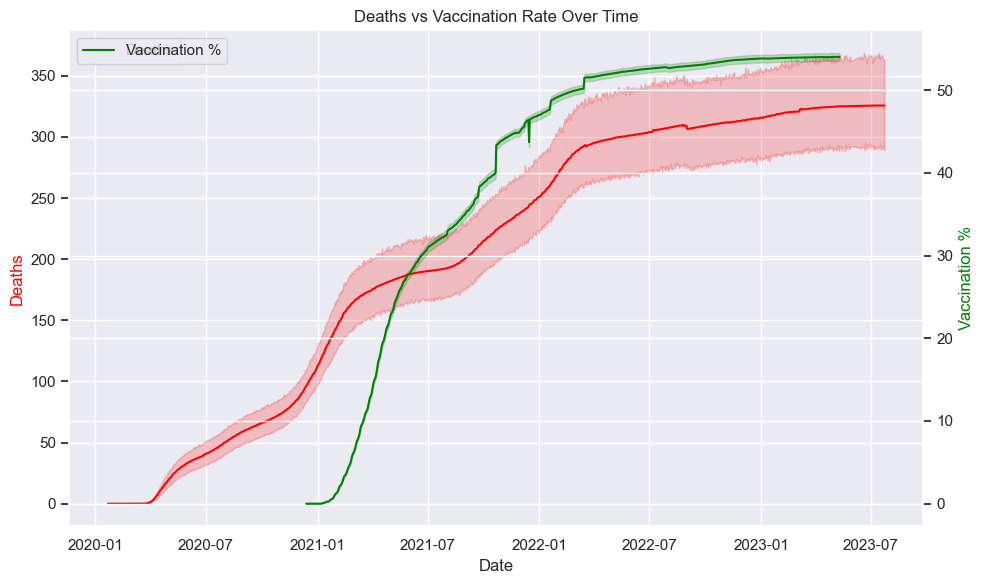

In [ ]:
df_plot = df_combined.reset_index()
df_plot["Date"] = pd.to_datetime(df_plot[["Year", "Month", "Day"]])
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(data=df_plot, x="Date", y="Deaths", ax=ax1, color="red", label="Deaths")
ax1.set_ylabel("Deaths", color="red")

ax2 = ax1.twinx()
sns.lineplot(data=df_plot, x="Date", y="Series_Complete_Pop_Pct", ax=ax2, color="green", label="Vaccination %")
ax2.set_ylabel("Vaccination %", color="green")

plt.title("Deaths vs Vaccination Rate Over Time")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

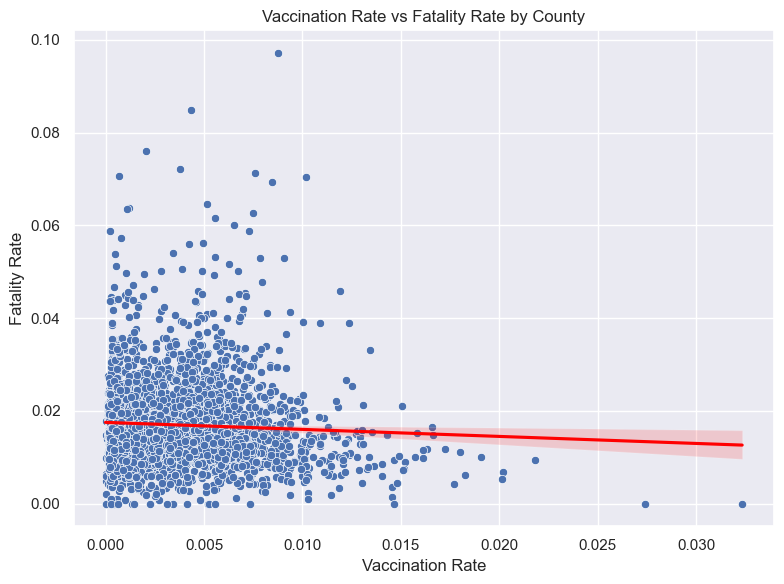

In [ ]:
if not {"Cases", "Deaths", "Series_Complete_Yes"}.issubset(df_combined.columns):
    df_combined = df_combined.reset_index()

research_question1 = df_combined[["FIPS", "Cases", "Deaths", "Series_Complete_Yes"]].copy()

research_question1 = research_question1.groupby("FIPS").agg({
    "Cases": "sum",
    "Deaths": "sum",
    "Series_Complete_Yes": "max"
}).reset_index()

research_question1["Vaccination_Rate"] = research_question1["Series_Complete_Yes"] / research_question1["Cases"]
research_question1["Fatality_Rate"] = research_question1["Deaths"] / research_question1["Cases"]


plt.figure(figsize=(8, 6))
sns.scatterplot(data=research_question1, x="Vaccination_Rate", y="Fatality_Rate")
sns.regplot(data=research_question1, x="Vaccination_Rate", y="Fatality_Rate", scatter=False, color="red")
plt.title("Vaccination Rate vs Fatality Rate by County")
plt.xlabel("Vaccination Rate")
plt.ylabel("Fatality Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
import numpy as np
from scipy.stats import pearsonr

research_question1_clean = research_question1.replace([np.inf, -np.inf], np.nan).dropna(subset=["Vaccination_Rate", "Fatality_Rate"])

pearson_r, pearson_p = pearsonr(
    research_question1_clean["Vaccination_Rate"],
    research_question1_clean["Fatality_Rate"]
)

print(f"Pearson r = {pearson_r:.3f} (p = {pearson_p:.4f})")

Pearson r = -0.054 (p = 0.0028)


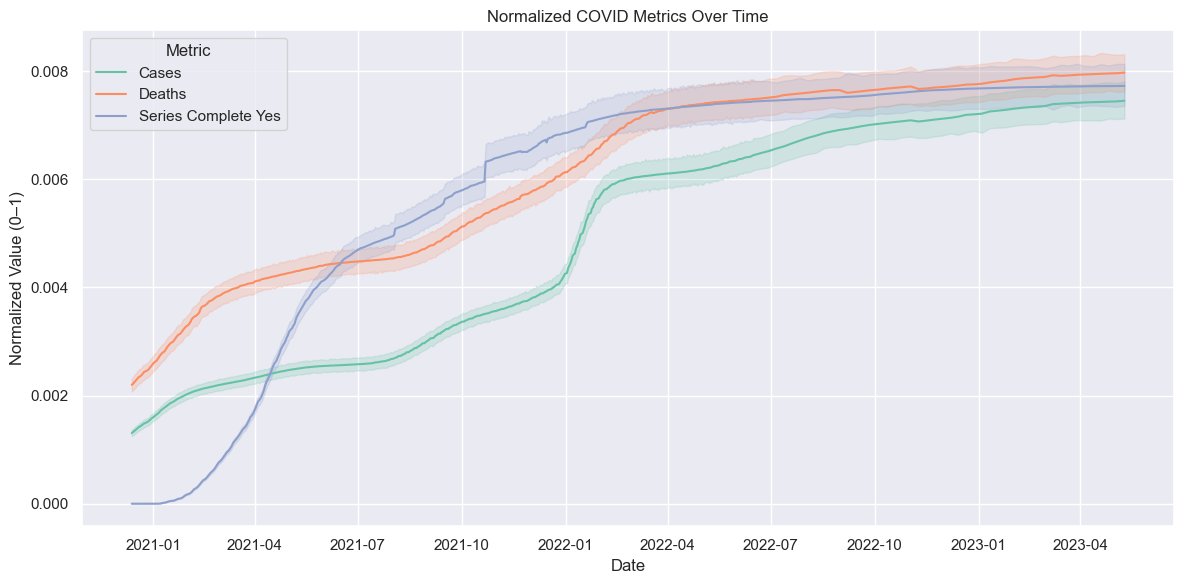

In [ ]:
df_plot = df_combined.reset_index()
df_plot["Date"] = pd.to_datetime(df_plot[["Year", "Month", "Day"]])
df_research_question_3 = df_plot.copy()

metrics = ["Cases", "Deaths", "Series_Complete_Yes"]

for col in metrics:
    df_research_question_3[col + "_norm"] = (df_research_question_3[col] - df_research_question_3[col].min()) / (df_research_question_3[col].max() - df_research_question_3[col].min())

df_melted = df_research_question_3.melt( id_vars=["Date"], value_vars=[col + "_norm" for col in metrics], var_name="Metric",
    value_name="Normalized Value"
)

df_melted["Metric"] = df_melted["Metric"].str.replace("_norm", "").str.replace("_", " ")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted, x="Date", y="Normalized Value", hue="Metric", palette="Set2")
plt.title("Normalized COVID Metrics Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Value (0–1)")
plt.grid(True)
plt.tight_layout()
plt.show()